In [34]:
# Jhose Immanuel Sembiring
# 1103202047
# TK44G4
# Modern-CNN_DenseNet

#Library

In [35]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


#Definisikan Dense Block

In [36]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, in_channels, out_channels):
        super(DenseBlock, self).__init__()
        net = []
        for i in range(num_convs):
            in_c = in_channels + i * out_channels
            net.append(self.conv_block(in_c, out_channels))
        self.net = nn.Sequential(*net)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X


#Definisikan Transition Layer

In [37]:
class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1)  # Tambahkan padding
        )

    def forward(self, X):
        return self.net(X)


#Definisikan Model DenseNet

In [38]:
class DenseNet(nn.Module):
    def __init__(self, num_channels, growth_rate, block_layers, num_classes):
        super(DenseNet, self).__init__()
        self.num_channels = num_channels
        self.growth_rate = growth_rate

        self.stem = nn.Sequential(
            nn.Conv2d(1, num_channels, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        layers = []
        for i, num_convs in enumerate(block_layers):
            layers.append(DenseBlock(num_convs, self.num_channels, growth_rate))
            self.num_channels += num_convs * growth_rate
            if i != len(block_layers) - 1:
                layers.append(TransitionBlock(self.num_channels, self.num_channels // 2))
                self.num_channels = self.num_channels // 2

        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.BatchNorm2d(self.num_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.num_channels, num_classes)
        )

    def forward(self, X):
        X = self.stem(X)
        X = self.features(X)
        X = self.classifier(X)
        return X


#Persiapkan Data

In [39]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet(num_channels=64, growth_rate=32, block_layers=[2, 2, 2, 2], num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Training Loop

In [40]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    print(f'Train Epoch: {epoch} Loss: {train_loss:.4f} Accuracy: {train_accuracy:.2f}%')
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')
    return test_loss, test_accuracy


#Training dan Visualisasi

Train Epoch: 1 Loss: 0.0022 Accuracy: 96.31%
Test set: Average loss: 0.0007, Accuracy: 98.62%
Train Epoch: 2 Loss: 0.0008 Accuracy: 98.41%
Test set: Average loss: 0.0007, Accuracy: 98.56%
Train Epoch: 3 Loss: 0.0006 Accuracy: 98.88%
Test set: Average loss: 0.0006, Accuracy: 98.85%
Train Epoch: 4 Loss: 0.0005 Accuracy: 99.03%
Test set: Average loss: 0.0005, Accuracy: 98.94%
Train Epoch: 5 Loss: 0.0004 Accuracy: 99.18%
Test set: Average loss: 0.0005, Accuracy: 99.06%
Train Epoch: 6 Loss: 0.0004 Accuracy: 99.29%
Test set: Average loss: 0.0005, Accuracy: 99.04%
Train Epoch: 7 Loss: 0.0003 Accuracy: 99.40%
Test set: Average loss: 0.0005, Accuracy: 99.09%
Train Epoch: 8 Loss: 0.0003 Accuracy: 99.42%
Test set: Average loss: 0.0004, Accuracy: 99.18%
Train Epoch: 9 Loss: 0.0003 Accuracy: 99.49%
Test set: Average loss: 0.0004, Accuracy: 99.31%
Train Epoch: 10 Loss: 0.0002 Accuracy: 99.62%
Test set: Average loss: 0.0004, Accuracy: 99.31%


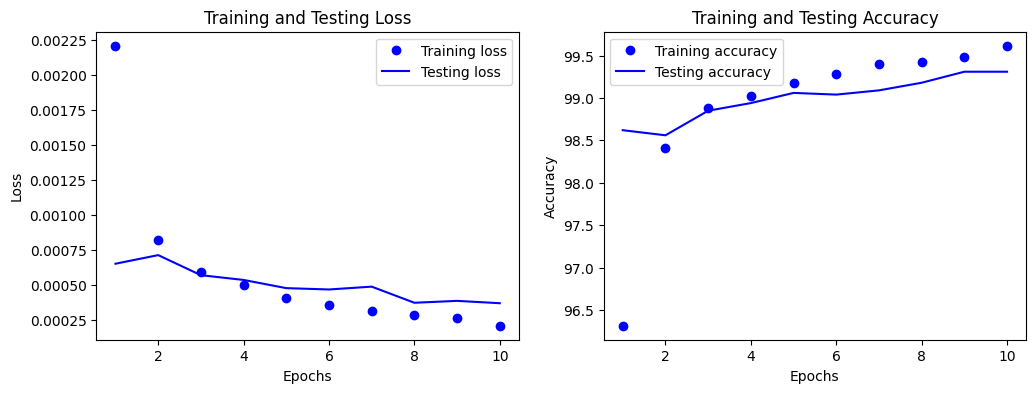

In [41]:
num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# Visualisasi Loss dan Akurasi
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, test_losses, 'b', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, test_accuracies, 'b', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
